In [0]:
#Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
# Import of keras model and hidden layers for our convolutional network
from keras import Sequential
from keras.layers import InputLayer
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
 
#Image handling libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
 
#Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
 
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [0]:
#DOWNLOADING KAGGLE DATASET INTO COLAB
from google.colab import files
files.upload()

#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d evernext10/hand-gesture-of-the-colombian-sign-language

Saving kaggle.json to kaggle.json
100% 21.9G/21.9G [06:10<00:00, 64.5MB/s]
100% 21.9G/21.9G [06:10<00:00, 63.5MB/s]


In [0]:
from zipfile import ZipFile
file_name="hand-gesture-of-the-colombian-sign-language.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("DONE")

DONE


In [0]:
#Initialize a list of paths for images
imagepaths = []

import os
for dirname, _, filenames in os.walk('/content/dataset/dataset'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if path.endswith("JPG"):
            imagepaths.append(path)
print(len(imagepaths))

3325


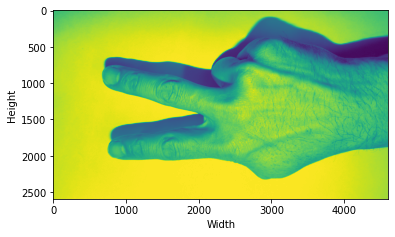

In [0]:
def img_plot(path):
  img=cv2.imread(path)
  #convert to RGB space
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  plt.imshow(img_rgb)
  plt.xlabel("Width")
  plt.ylabel("Height")

img_plot(imagepaths[509])

In [0]:
#### Creating Training Set and Labels ####
# X for image data
X = []
# y for the labels
y = []
#Load the images into X by doing the necessary conversions and resizing of images
#Resizing is done to reduce the size of image to increase the speed of training
for i in range(len(imagepaths)):
    path=imagepaths[i]
    img = cv2.imread(path)
    if type(img)==type(None):
      continue
    else:
      img = cv2.resize(img, (224,224))
      X.append(img)  
      #Getting the labels from the image path
      y_lab=imagepaths[i][31]
      if y_lab=='0' or y_lab=='1' or y_lab=='2' or y_lab=='3' or y_lab=='4' or y_lab=='5':
        label=int(y_lab)
      elif y_lab=='A':
        label=6
      elif y_lab=='E':
        label=7
      elif y_lab=='I':
        label=8
      elif y_lab=='O':
        label=9
      else :
        label=10
      y.append(label)

#Turning X & y into numpy arrays
X = np.array(X)
X = X.reshape(len(X), 224,224,3)
y = np.array(y)

print(X.shape)
print(y.shape)


(3319, 224, 224, 3)
(3319,)


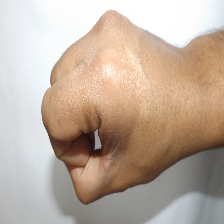

--------------------------------- 0 




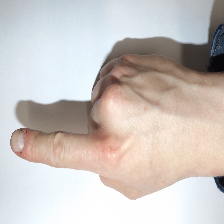

--------------------------------- 1 




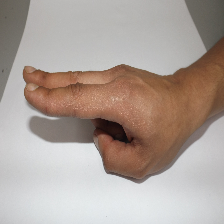

--------------------------------- 2 




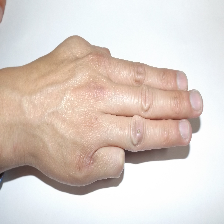

--------------------------------- 3 




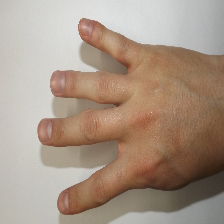

--------------------------------- 4 




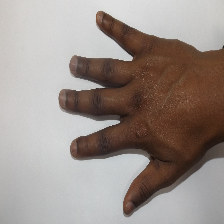

--------------------------------- 5 




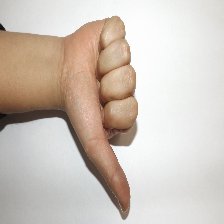

--------------------------------- A 




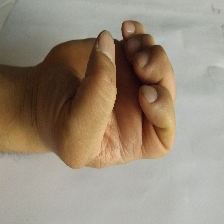

--------------------------------- E 




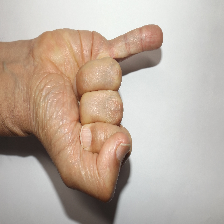

--------------------------------- I 




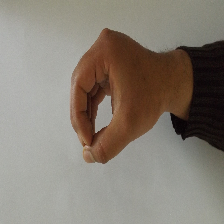

--------------------------------- O 




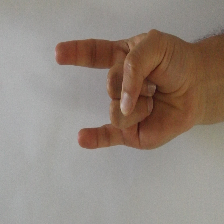

--------------------------------- U 




In [0]:
for i in range(11):
  for j in range(X.shape[0]):
    if y[j]==i:
      cv2_imshow(X[j])
      if y[j]==6:
        k='A'
      elif y[j]==7:
        k='E'
      elif y[j]==8:
        k='I'
      elif y[j]==9:
        k='O'
      elif y[j]==10:
        k='U'
      else:
        k=y[j]
      print("---------------------------------",k,"\n\n")
      break
    else:
      continue



In [0]:
# Make the test train split
threshold = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = threshold, random_state = 42)
print(X_train.shape)
print(y_train.shape)

(2323, 224, 224, 3)
(2323,)


In [0]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 7s 0us/step


In [0]:
vgg16_model.summary()
print(len(vgg16_model.layers))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model = tf.keras.Sequential()
l=len(vgg16_model.layers)-1
for i in range(l):
    layer=vgg16_model.layers[i]
    model.add(layer)
for layer in model.layers:
    layer.trainable = False
model.add(tf.keras.layers.Dense(11, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [0]:
#Model configuration for training purpose
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2,validation_data=(X_test, y_test))

Epoch 1/5
37/37 - 1711s - loss: 1.9394 - accuracy: 0.3711 - val_loss: 1.3489 - val_accuracy: 0.5331
Epoch 2/5
37/37 - 1716s - loss: 1.0896 - accuracy: 0.6096 - val_loss: 1.0855 - val_accuracy: 0.6094
Epoch 3/5
37/37 - 1689s - loss: 0.8138 - accuracy: 0.7219 - val_loss: 0.9807 - val_accuracy: 0.6185
Epoch 4/5
37/37 - 1684s - loss: 0.6716 - accuracy: 0.7774 - val_loss: 0.9489 - val_accuracy: 0.6566
Epoch 5/5
37/37 - 1654s - loss: 0.5668 - accuracy: 0.8214 - val_loss: 0.9237 - val_accuracy: 0.6677


In [0]:
#calculate loss and accuracy on test data

tLoss, tAccuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(tAccuracy*100))

32/32 [==============================] - 502s 16s/step - loss: 0.9237 - accuracy: 0.6677
Test accuracy: 66.77%


In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/gesture_detection/DATA2_mod2.h5')

In [0]:
y_pred=np.argmax(model.predict(X_test),axis=1) # Make predictions towards the test set

In [0]:
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["0","1","2","3","4","5","A","E","I","O","U"],
             index=["0","1","2","3","4","5","A","E","I","O","U"])

,0,1,2,3,4,5,A,E,I,O,U
0,63,4,0,0,0,0,1,2,6,15,0
1,2,73,6,0,1,0,0,2,1,1,3
2,0,18,41,19,0,0,1,0,0,0,6
3,0,7,15,52,5,7,1,2,1,0,4
4,0,2,2,30,26,29,0,4,0,0,2
5,0,0,0,1,3,91,0,0,0,0,1
A,0,4,1,1,0,0,75,1,2,0,0
E,5,3,0,0,1,0,8,69,2,0,0
I,4,8,0,1,0,2,6,1,60,0,15
O,36,3,0,0,0,0,1,4,4,41,2
